Here, we would like to implement a multivariate time series LSTM model that utilizes historical prices along with technical indicators to predict prices.

<img src="https://api.wandb.ai/files/ayush-thakur/images/projects/103390/4fc355be.png" width=500 height=300>

In [1]:
import os
import numpy as np
from Functions.sp500.sp500 import get_sp500_tickers
import matplotlib.pyplot as plt

In [2]:
def load_data(tickers, dev_split = False):
    final_X, final_y = None, None
    for ticker in tickers:
        print(f"Loading {ticker}")
        a = f"../Functions/csv_files/sampling_data/{ticker}/X.npy"
        b = f"../Functions/csv_files/sampling_data/{ticker}/y.npy"
        if not os.path.exists(a) or not os.path.exists(b):
            print(f"No {ticker} data")
            continue
        data_X = np.load(a, allow_pickle=True)
        data_y = np.load(b, allow_pickle=True)
        if len(data_X.shape) != 3 or data_X.shape[1] != 14 or data_X.shape[2] != 7:
            print(f"{ticker} is corrupted: Training Data is incorrect")
            continue
        if len(data_y.shape) != 1 or data_y.shape[0] != data_X.shape[0]:
            print(f"{ticker} is corrupted: Label is incorrect")
            continue
        if final_X is None and final_y is None:
            final_X = data_X
            final_y = data_y
        else:
            final_X = np.append(final_X, data_X, axis=0)
            final_y = np.append(final_y, data_y, axis=0)
    if dev_split:
        n = len(final_X)
        train = int(n * 0.9)
        dev = n - train
        return final_X[:train], final_y[:train], final_X[-dev:], final_y[-dev:]
    return final_X, final_y, None, None

In [3]:
tickers = get_sp500_tickers(False)
end = tickers.index("WTW.US")
tickers = tickers[:end]
print(tickers)

['AAPL.US', 'MSFT.US', 'AMZN.US', 'TSLA.US', 'GOOGL.US', 'GOOG.US', 'BRKB.US', 'UNH.US', 'JNJ.US', 'XOM.US', 'META.US', 'JPM.US', 'NVDA.US', 'PG.US', 'V.US', 'HD.US', 'CVX.US', 'LLY.US', 'PFE.US', 'MA.US', 'ABBV.US', 'PEP.US', 'MRK.US', 'KO.US', 'BAC.US', 'COST.US', 'TMO.US', 'WMT.US', 'AVGO.US', 'DIS.US', 'MCD.US', 'ABT.US', 'DHR.US', 'CSCO.US', 'ACN.US', 'VZ.US', 'NEE.US', 'WFC.US', 'BMY.US', 'CRM.US', 'TXN.US', 'LIN.US', 'COP.US', 'CMCSA.US', 'ADBE.US', 'PM.US', 'QCOM.US', 'CVS.US', 'UNP.US', 'RTX.US', 'AMGN.US', 'LOW.US', 'UPS.US', 'HON.US', 'SCHW.US', 'T.US', 'ELV.US', 'INTU.US', 'IBM.US', 'MDT.US', 'INTC.US', 'MS.US', 'NKE.US', 'NFLX.US', 'SPGI.US', 'AMD.US', 'GS.US', 'AMT.US', 'PYPL.US', 'SBUX.US', 'ADP.US', 'DE.US', 'ORCL.US', 'LMT.US', 'CAT.US', 'CI.US', 'BLK.US', 'AXP.US', 'TMUS.US', 'C.US', 'GILD.US', 'NOW.US', 'CB.US', 'PLD.US', 'MDLZ.US', 'MMC.US', 'VRTX.US', 'REGN.US', 'ADI.US', 'TJX.US', 'MO.US', 'SO.US', 'DUK.US', 'AMAT.US', 'ZTS.US', 'TGT.US', 'NOC.US', 'SYK.US', 'PGR.

In [5]:
X, y, X_dev, y_dev = load_data(tickers, True)

Loading AAPL.US
Loading MSFT.US
Loading AMZN.US
Loading TSLA.US
Loading GOOGL.US
Loading GOOG.US
Loading BRKB.US
Loading UNH.US
Loading JNJ.US
Loading XOM.US
Loading META.US
Loading JPM.US
Loading NVDA.US
Loading PG.US
Loading V.US
Loading HD.US
Loading CVX.US
Loading LLY.US
Loading PFE.US
Loading MA.US
Loading ABBV.US
Loading PEP.US
Loading MRK.US
Loading KO.US
Loading BAC.US
Loading COST.US
Loading TMO.US
Loading WMT.US
Loading AVGO.US
Loading DIS.US
Loading MCD.US
Loading ABT.US
Loading DHR.US
Loading CSCO.US
Loading ACN.US
Loading VZ.US
Loading NEE.US
Loading WFC.US
Loading BMY.US
Loading CRM.US
Loading TXN.US
Loading LIN.US
Loading COP.US
Loading CMCSA.US
Loading ADBE.US
Loading PM.US
Loading QCOM.US
Loading CVS.US
Loading UNP.US
Loading RTX.US
Loading AMGN.US
Loading LOW.US
Loading UPS.US
Loading HON.US
Loading SCHW.US
Loading T.US
Loading ELV.US
Loading INTU.US
Loading IBM.US
Loading MDT.US
Loading INTC.US
Loading MS.US
Loading NKE.US
Loading NFLX.US
Loading SPGI.US
Loading AMD.

<h1>Data Cleaning</h1>

In [9]:
def remove_date(X):
    X2 = np.delete(X, 0, 2)
    X2 = np.asarray(X2).astype(np.float32)
    return X2

In [10]:
X_train = remove_date(X)
if X_dev is not None:
    X_dev = remove_date(X_dev)

In [11]:
def check_nan(X):
    array = []
    for index, x in enumerate(X):
        if np.isnan(x).any():
            print(index)
            array.append(index)
    return array

In [12]:
def fill_missing_rsi_values(X_train, null_lst):
    train = X_train.copy()
    for i in null_lst:
        train[i][:, 4][0] = X_train[i][:, 4][1]
    return train

In [13]:
null_list = check_nan(X_train)
X_train = fill_missing_rsi_values(X_train, null_list)

if X_dev is not None:
    X_dev = fill_missing_rsi_values(X_dev, check_nan(X_dev))

3071
3862
4044
4172
4390
5369
85
93
116
544


In [14]:
print(check_nan(X_train))
print(check_nan(X_dev))

[]
[]


In [15]:
def plot_history(history):
    # summarize history for accuracy

    legend = ['train']
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if "val_loss" in history.history.keys():
        plt.plot(history.history['val_loss'])
        legend.append('val')
          
    # summarize history for loss

    plt.legend(legend, loc='upper left')
    plt.show()    

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

<h1>Control Model</h1>

This control model accepts historical prices as the only feature only. It will be used to create a benchmark for future models.

In [18]:
X_train_control = X_train[:,:,0]
print(X_train_control.shape)
X_dev_control = X_dev[:, :, 0]
print(X_dev_control.shape)

(6007, 14)
(668, 14)


In [19]:
control_model = Sequential()
control_model.add(LSTM(32, activation='relu', input_shape=(14, 1)))
control_model.add(Dense(1))
control_model.compile(optimizer='adam', loss='mse')

control_history = control_model.fit(X_train_control, y, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
151/151 [==============================] - 3s 10ms/step - loss: 9547.5371 - val_loss: 61.7260
Epoch 2/30
151/151 [==============================] - 1s 8ms/step - loss: 7460.3672 - val_loss: 32.4348
Epoch 3/30
151/151 [==============================] - 1s 8ms/step - loss: 412.7776 - val_loss: 24.8129
Epoch 4/30
151/151 [==============================] - 1s 8ms/step - loss: 160.3427 - val_loss: 36.2750
Epoch 5/30
151/151 [==============================] - 1s 8ms/step - loss: 169.7748 - val_loss: 37.3995
Epoch 6/30
151/151 [==============================] - 1s 8ms/step - loss: 172.9731 - val_loss: 26.6116
Epoch 7/30
151/151 [==============================] - 1s 8ms/step - loss: 96.7669 - val_loss: 24.4150
Epoch 8/30
151/151 [==============================] - 1s 8ms/step - loss: 111.9210 - val_loss: 31.9280
Epoch 9/30
151/151 [==============================] - 1s 8ms/step - loss: 108.0672 - val_loss: 37.8868
Epoch 10/30
151/151 [==============================] - 1s 8ms/step - lo

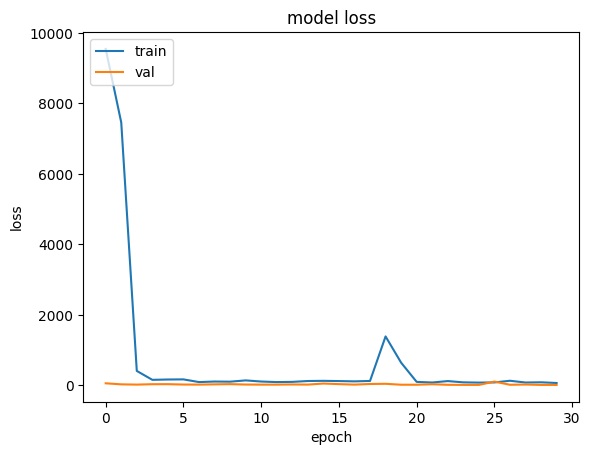

In [20]:
plot_history(control_history)

<h1>Data Exploration</h1>

In [21]:
import datetime as dt
dates = [dt.datetime.strptime(i[0], "%Y-%m-%d").date() for i in X[:,0,:]]

In [22]:
from collections import Counter
count_date = dict(Counter(dates))

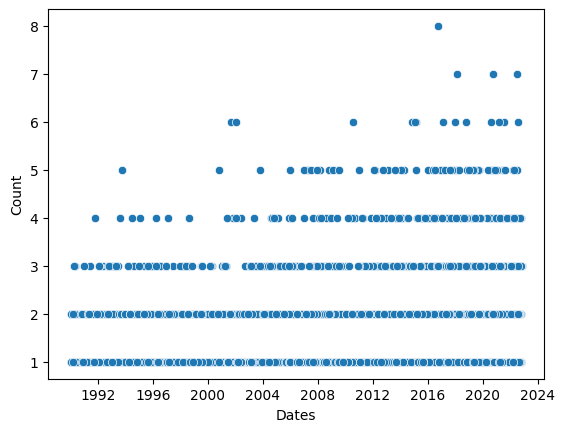

In [23]:
import seaborn as sns
ax = sns.scatterplot(x=count_date.keys(), y=count_date.values())
ax.set(xlabel='Dates', ylabel='Count')
plt.show()

The distribution of data is relatively even, Although it's skewed towards more recent dates.

<h1>Data Transformation</h1>

In [24]:
sample = X_train[0]

In [25]:
sample

array([[3.590850e+01, 1.950096e+08, 3.445640e+01, 1.639000e-01,
        7.583090e+01, 5.258000e-01],
       [3.613850e+01, 1.565216e+08, 3.472800e+01, 1.863000e-01,
        7.728230e+01, 6.881000e-01],
       [3.596720e+01, 1.032228e+08, 3.494700e+01, 2.037000e-01,
        7.373100e+01, 7.906000e-01],
       [3.627820e+01, 1.090204e+08, 3.518340e+01, 2.175000e-01,
        7.589660e+01, 8.831000e-01],
       [3.678490e+01, 1.301080e+08, 3.545970e+01, 2.436000e-01,
        7.894240e+01, 1.069900e+00],
       [3.669060e+01, 1.040388e+08, 3.569420e+01, 2.605000e-01,
        7.699250e+01, 1.178300e+00],
       [3.663640e+01, 8.019400e+07, 3.589510e+01, 2.570000e-01,
        7.583300e+01, 1.154800e+00],
       [3.540630e+01, 2.030708e+08, 3.590420e+01, 2.064000e-01,
        5.543100e+01, 9.596000e-01],
       [3.594600e+01, 1.342728e+08, 3.596940e+01, 1.628000e-01,
        6.045760e+01, 7.337000e-01],
       [3.606850e+01, 1.078432e+08, 3.602960e+01, 1.356000e-01,
        6.151850e+01, 6.283

In [26]:
from sklearn.preprocessing import MinMaxScaler

def scale_column(x, column = 1):
    """
    Doesn't mutate the original array
    """
    mms = MinMaxScaler()
    x2 = x.copy()
    # The volume column has index 1
    x2[:, 1] = mms.fit_transform(x2[:, column].reshape(14, 1)).reshape(14,)
    return x2

In [27]:
scale_column(sample)

array([[3.5908501e+01, 9.3620390e-01, 3.4456402e+01, 1.6390000e-01,
        7.5830902e+01, 5.2579999e-01],
       [3.6138500e+01, 6.3161093e-01, 3.4728001e+01, 1.8629999e-01,
        7.7282303e+01, 6.8809998e-01],
       [3.5967201e+01, 2.0980573e-01, 3.4946999e+01, 2.0370001e-01,
        7.3731003e+01, 7.9060000e-01],
       [3.6278198e+01, 2.5568777e-01, 3.5183399e+01, 2.1750000e-01,
        7.5896599e+01, 8.8309997e-01],
       [3.6784901e+01, 4.2257446e-01, 3.5459702e+01, 2.4360000e-01,
        7.8942398e+01, 1.0699000e+00],
       [3.6690601e+01, 2.1626353e-01, 3.5694199e+01, 2.6050001e-01,
        7.6992500e+01, 1.1783000e+00],
       [3.6636398e+01, 2.7556419e-02, 3.5895100e+01, 2.5700000e-01,
        7.5833000e+01, 1.1548001e+00],
       [3.5406300e+01, 9.9999994e-01, 3.5904202e+01, 2.0640001e-01,
        5.5431000e+01, 9.5959997e-01],
       [3.5945999e+01, 4.5553452e-01, 3.5969398e+01, 1.6280000e-01,
        6.0457600e+01, 7.3369998e-01],
       [3.6068501e+01, 2.4637145e-01,

In [28]:
check_rsi = lambda rsi: 0 if rsi is np.nan or (70 > rsi > 30) else (-1 if rsi < 30 else 1)
"""
Traditionally, RSI > 70 = Overbought, RSI < 30 Oversold
We transform the column to -1, 0, 1,
"""
vectorized_check_rsi = np.vectorize(check_rsi)

def rsi_transformer(x):
    x2 = x.copy()
    rsi_column = x2[:, 4]
    x2[:, 4] = vectorized_check_rsi(rsi_column)
    return x2

In [29]:
rsi_transformer(sample)

array([[3.590850e+01, 1.950096e+08, 3.445640e+01, 1.639000e-01,
        1.000000e+00, 5.258000e-01],
       [3.613850e+01, 1.565216e+08, 3.472800e+01, 1.863000e-01,
        1.000000e+00, 6.881000e-01],
       [3.596720e+01, 1.032228e+08, 3.494700e+01, 2.037000e-01,
        1.000000e+00, 7.906000e-01],
       [3.627820e+01, 1.090204e+08, 3.518340e+01, 2.175000e-01,
        1.000000e+00, 8.831000e-01],
       [3.678490e+01, 1.301080e+08, 3.545970e+01, 2.436000e-01,
        1.000000e+00, 1.069900e+00],
       [3.669060e+01, 1.040388e+08, 3.569420e+01, 2.605000e-01,
        1.000000e+00, 1.178300e+00],
       [3.663640e+01, 8.019400e+07, 3.589510e+01, 2.570000e-01,
        1.000000e+00, 1.154800e+00],
       [3.540630e+01, 2.030708e+08, 3.590420e+01, 2.064000e-01,
        0.000000e+00, 9.596000e-01],
       [3.594600e+01, 1.342728e+08, 3.596940e+01, 1.628000e-01,
        0.000000e+00, 7.337000e-01],
       [3.606850e+01, 1.078432e+08, 3.602960e+01, 1.356000e-01,
        0.000000e+00, 6.283

In [30]:
def pipeline(X):
    array = []
    for x in X:
        a = scale_column(x)
        b = rsi_transformer(a)
        array.append(b)
    return np.array(array)

In [31]:
X_train[3071]

array([[ 7.38800e-01,  3.60000e+03,  7.70100e-01, -2.00000e-03,
         4.79129e+01,  2.30000e-03],
       [ 7.20300e-01,  1.20000e+04,  7.62900e-01, -4.10000e-03,
         4.79129e+01,  2.40000e-03],
       [ 8.12700e-01,  4.80000e+03,  7.68300e-01, -2.80000e-03,
         5.31701e+01,  2.60000e-03],
       [ 7.01900e-01,  1.32000e+04,  7.58700e-01, -3.00000e-03,
         4.70391e+01,  2.60000e-03],
       [ 7.01900e-01,  2.40000e+04,  7.50200e-01, -5.70000e-03,
         4.70391e+01,  2.80000e-03],
       [ 7.38800e-01,  3.48000e+04,  7.47100e-01, -4.10000e-03,
         4.92972e+01,  2.50000e-03],
       [ 6.64900e-01,  6.24000e+04,  7.34900e-01, -7.30000e-03,
         4.51456e+01,  3.10000e-03],
       [ 6.28000e-01,  3.84000e+04,  7.18600e-01, -1.12000e-02,
         4.31897e+01,  4.10000e-03],
       [ 6.09500e-01,  2.76000e+04,  7.00800e-01, -1.08000e-02,
         4.22026e+01,  3.90000e-03],
       [ 6.46400e-01,  8.88000e+04,  6.90400e-01, -1.26000e-02,
         4.49074e+01,  4.20

In [40]:
X_train_final = pipeline(X_train)
X_dev_final = pipeline(X_dev)

In [41]:
NUM_OF_TIMESTEPS = 14
NUM_OF_FEATURES = 6

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(NUM_OF_TIMESTEPS, NUM_OF_FEATURES)))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4992      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam', loss='mse')

In [43]:
history = model.fit(X_train_final, y, epochs=100, validation_split=0.05, verbose=1)

Epoch 1/100
179/179 [==============================] - 3s 8ms/step - loss: 7293.2178 - val_loss: 515.6303
Epoch 2/100
179/179 [==============================] - 1s 7ms/step - loss: 3146.1689 - val_loss: 751.4041
Epoch 3/100
179/179 [==============================] - 1s 8ms/step - loss: 3507.0894 - val_loss: 272.1642
Epoch 4/100
179/179 [==============================] - 1s 8ms/step - loss: 1606.0403 - val_loss: 137.3788
Epoch 5/100
179/179 [==============================] - 1s 7ms/step - loss: 1933.3278 - val_loss: 156.7665
Epoch 6/100
179/179 [==============================] - 1s 7ms/step - loss: 1811.9255 - val_loss: 210.8175
Epoch 7/100
179/179 [==============================] - 1s 7ms/step - loss: 1288.0002 - val_loss: 154.2593
Epoch 8/100
179/179 [==============================] - 1s 8ms/step - loss: 1775.3569 - val_loss: 366.7251
Epoch 9/100
179/179 [==============================] - 1s 7ms/step - loss: 1923.9231 - val_loss: 58.3866
Epoch 10/100
179/179 [=========================

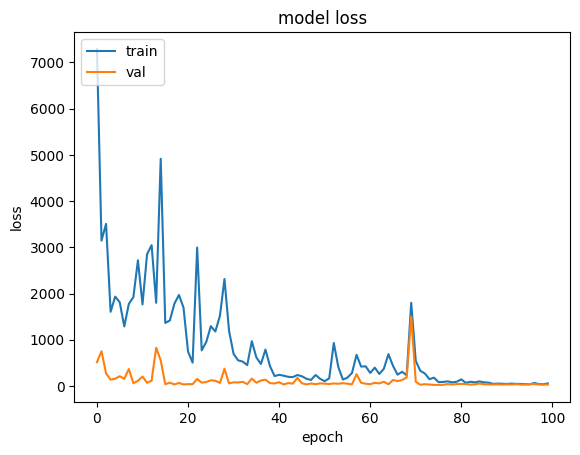

In [44]:
plot_history(history)

In [45]:
model.evaluate(X_train_final, y)

188/188 [==============================] - 1s 4ms/step - loss: 37.6673


37.66726303100586

In [46]:
control_model.evaluate(X_train_control, y)

188/188 [==============================] - 1s 4ms/step - loss: 47.0910


47.09095764160156

In [47]:
model.evaluate(X_dev_final, y_dev)

21/21 [==============================] - 0s 4ms/step - loss: 20.3559


20.355947494506836

In [67]:
control_model.evaluate(X_dev_control, y_dev)

21/21 [==============================] - 0s 5ms/step - loss: 29.9381


29.93813133239746